Import first necessary library

In [1]:
import os

We have to import `kaggle.json` file to download dataset and prepare directory to extract zip file we will download.

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maryanpetlyovanyy","key":"d1656d34430a1dedc3c4b95bd129d671"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d khlaifiabilel/military-aircraft-recognition-dataset -p /content/


100% 1.12G/1.13G [00:10<00:00, 134MB/s]
100% 1.13G/1.13G [00:10<00:00, 111MB/s]


In [5]:
!unzip /content/military-aircraft-recognition-dataset.zip -d /content/military-aircraft-recognition-dataset/


Streaming output truncated to the last 5000 lines.
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3416.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3417.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3418.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3419.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/342.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3420.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3421.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3422.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxe

Also you can upload model config

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maryanpetlyovanyy","key":"d1656d34430a1dedc3c4b95bd129d671"}'}

In [7]:
config = None
try:
  with open('model2.yaml', 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
except:
    print("No yaml config found")
if config:
  INPUT_SIZE = config['INPUT_SIZE']
  N_SAMPLES = config['N_SAMPLES']
  LR = float(config['LR'])
  BATCH_SIZE = config['BATCH_SIZE']
  EPOCHS = config['EPOCHS']
else:
  INPUT_SIZE = (224,224)
  N_SAMPLES = 1000
  LR = 1e-3
  BATCH_SIZE = 32
  EPOCHS = 10

No yaml config found


This is specific config for google colab

Also there are some detection parameters

In [8]:
ORIG_BASE_PATH = "/content/military-aircraft-recognition-dataset"
ORIG_IMAGES = "/content/military-aircraft-recognition-dataset/JPEGImages"
ORIG_ANNOTS = "/content/military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes"

BASE_PATH = "/content/new_data"
POSITVE_PATH = os.path.sep.join([BASE_PATH, "aircraft"])
NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_aircraft"])

MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200

MAX_POSITIVE = 30
MAX_NEGATIVE = 10

MODEL_PATH = "aircraft_detector.h5"
ENCODER_PATH = "label_encoder.pickle"


MIN_PROBA = 0.01

Define function to computer intersection over union and non max suppression

In [9]:
def compute_iou(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	iou = interArea / float(boxAArea + boxBArea - interArea)

	return iou

In [10]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	if len(boxes) == 0:
		return []

	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	pick = []

	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	if probs is not None:
		idxs = probs

	idxs = np.argsort(idxs)

	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		overlap = (w * h) / area[idxs[:last]]

		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	return pick

Make dirs for preprocessing dataset

In [11]:
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import os

# loop over the output positive and negative directories
for dirPath in (POSITVE_PATH, NEGATIVE_PATH):
	# if the output directory does not exist yet, create it
	if not os.path.exists(dirPath):
		os.makedirs(dirPath)



In [12]:
imagePaths = list(paths.list_images(ORIG_IMAGES))

In [13]:
totalPositive = 0
totalNegative = 0

Preprocessing of the dataset

Creating aircraft/no_aircraft imagesets

In [15]:
class_image_counts = {}


for (i, imagePath) in enumerate(imagePaths):
  print("[INFO] processing image {}/{}...".format(i + 1, len(imagePaths)))
  print(class_image_counts)

  filename = imagePath.split(os.path.sep)[-1]
  print("--------------filename", filename)
  filename = filename[:filename.rfind(".")]
  print("-------------------------filename", filename)
  annotPath = os.path.sep.join([ORIG_ANNOTS,"{}.xml".format(filename)])

  contents = open(annotPath).read()
  soup = BeautifulSoup(contents, "html.parser")
  gtBoxes = []


  w = int(soup.find("width").string)
  h = int(soup.find("height").string)


  switch = False
  for o in soup.find_all("object"):

    label = o.find("name").string
    if label in class_image_counts and class_image_counts[label] >= 100:
        switch = True
        continue
    xMin = int(o.find("xmin").string)
    yMin = int(o.find("ymin").string)
    xMax = int(o.find("xmax").string)
    yMax = int(o.find("ymax").string)

    xMin = max(0, xMin)
    yMin = max(0, yMin)
    xMax = min(w, xMax)
    yMax = min(h, yMax)

    gtBoxes.append((xMin, yMin, xMax, yMax))
  if switch:
    switch = False
    continue
  image = cv2.imread(imagePath)


  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()
  print("[INFO] SelectiveSearch Result/{}, len={}\n{}".format(i + 1, len(rects), rects))
  proposedRects= []

  for (x, y, w, h) in rects:
    proposedRects.append((x, y, x + w, y + h))

  positiveROIs = 0
  negativeROIs = 0

  for proposedRect in proposedRects[:MAX_PROPOSALS]:
    (propStartX, propStartY, propEndX, propEndY) = proposedRect

    for gtBox in gtBoxes:

      iou = compute_iou(gtBox, proposedRect)
      (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

      roi = None
      outputPath = None


      if iou > 0.7 and positiveROIs <= MAX_POSITIVE:

        roi = image[propStartY:propEndY, propStartX:propEndX]
        filename = "{}.jpg".format(totalPositive)
        outputPath = os.path.sep.join([POSITVE_PATH, filename])

        positiveROIs += 1
        totalPositive += 1

      fullOverlap = propStartX >= gtStartX
      fullOverlap = fullOverlap and propStartY >= gtStartY
      fullOverlap = fullOverlap and propEndX <= gtEndX
      fullOverlap = fullOverlap and propEndY <= gtEndY


      if not fullOverlap and iou < 0.05 and \
        negativeROIs <= MAX_NEGATIVE:
        roi = image[propStartY:propEndY, propStartX:propEndX]
        filename = "{}.jpg".format(totalNegative)
        outputPath = os.path.sep.join([NEGATIVE_PATH, filename])

        negativeROIs += 1
        totalNegative += 1

      if roi is not None and outputPath is not None:
        if label in class_image_counts:
            class_image_counts[label] += 1
        else:
            class_image_counts[label] = 1
        roi = cv2.resize(roi, INPUT_SIZE, interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(outputPath, roi)


Streaming output truncated to the last 5000 lines.
[INFO] processing image 2593/3842...
{'A11': 116, 'A1': 115, 'A13': 136, 'A4': 112, 'A5': 122, 'A16': 113, 'A2': 106, 'A10': 138, 'A20': 119, 'A3': 120, 'A18': 103, 'A7': 116, 'A8': 126, 'A15': 109, 'A6': 102, 'A19': 114, 'A12': 108, 'A9': 126, 'A17': 110, 'A14': 121}
--------------filename 2127.jpg
-------------------------filename 2127
[INFO] processing image 2594/3842...
{'A11': 116, 'A1': 115, 'A13': 136, 'A4': 112, 'A5': 122, 'A16': 113, 'A2': 106, 'A10': 138, 'A20': 119, 'A3': 120, 'A18': 103, 'A7': 116, 'A8': 126, 'A15': 109, 'A6': 102, 'A19': 114, 'A12': 108, 'A9': 126, 'A17': 110, 'A14': 121}
--------------filename 3275.jpg
-------------------------filename 3275
[INFO] processing image 2595/3842...
{'A11': 116, 'A1': 115, 'A13': 136, 'A4': 112, 'A5': 122, 'A16': 113, 'A2': 106, 'A10': 138, 'A20': 119, 'A3': 120, 'A18': 103, 'A7': 116, 'A8': 126, 'A15': 109, 'A6': 102, 'A19': 114, 'A12': 108, 'A9': 126, 'A17': 110, 'A14': 121}


Let's check image count

In [16]:
!ls -l /content/new_data/aircraft/*.jpg | wc -l
!ls -l /content/new_data/no_aircraft/*.jpg | wc -l

1585
825


Let's do necessary imports to train our model


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os

Let's load our images

In [18]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(BASE_PATH))
imagePaths = imagePaths[::5]
data = []
labels = []


for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]

	image = load_img(imagePath, target_size=INPUT_SIZE)
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)
print(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...
['no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircraft'
 'no_aircraft' 'no_aircraft' 'no_aircraft' 'no_aircr

And split to the train and test using sklearn

In [19]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

I think that augmentation would not hurt

In [20]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


Let's define our model and compile it

For the second model I'm going to try VGG16 model what seems to be a good for  classification task.

I'm going to use Tensorflow Functional API because I am going to make classification head.

I am going to use:

*   Adaptive momentum optimizer with learning rate(without learning rate scheduling for now)

*   Categorical binary crossentropy for classification

*   Accuracy metrics

In [21]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

58889256/58889256 [==============================] - 0s 0us/step


[INFO] compiling model...


And finally train the model

In [22]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	steps_per_epoch=len(trainX) // BATCH_SIZE,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BATCH_SIZE,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/50
12/12 [==============================] - 26s 1s/step - loss: 0.6497 - accuracy: 0.6487 - val_loss: 0.5438 - val_accuracy: 0.6598
Epoch 2/50
12/12 [==============================] - 6s 482ms/step - loss: 0.5451 - accuracy: 0.7110 - val_loss: 0.4291 - val_accuracy: 0.8763
Epoch 3/50
12/12 [==============================] - 5s 409ms/step - loss: 0.4492 - accuracy: 0.8159 - val_loss: 0.3734 - val_accuracy: 0.9072
Epoch 4/50
12/12 [==============================] - 5s 401ms/step - loss: 0.3748 - accuracy: 0.8952 - val_loss: 0.3285 - val_accuracy: 0.9278
Epoch 5/50
12/12 [==============================] - 5s 426ms/step - loss: 0.3558 - accuracy: 0.8802 - val_loss: 0.3036 - val_accuracy: 0.9175
Epoch 6/50
12/12 [==============================] - 6s 497ms/step - loss: 0.3388 - accuracy: 0.8754 - val_loss: 0.2881 - val_accuracy: 0.9175
Epoch 7/50
12/12 [==============================] - 5s 397ms/step - loss: 0.3127 - accuracy: 0.8924 - val_loss: 0.2811 - val_a

After training it worth evaluating the model

In [23]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)


predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
4/4 [==============================] - 1s 131ms/step
              precision    recall  f1-score   support

    aircraft       0.91      0.98      0.95        64
 no_aircraft       0.96      0.82      0.89        33

    accuracy                           0.93        97
   macro avg       0.94      0.90      0.92        97
weighted avg       0.93      0.93      0.93        97



Also we can save the model we have

In [24]:
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH, save_format="h5")

print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


And analyse history plot

In [25]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']


  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

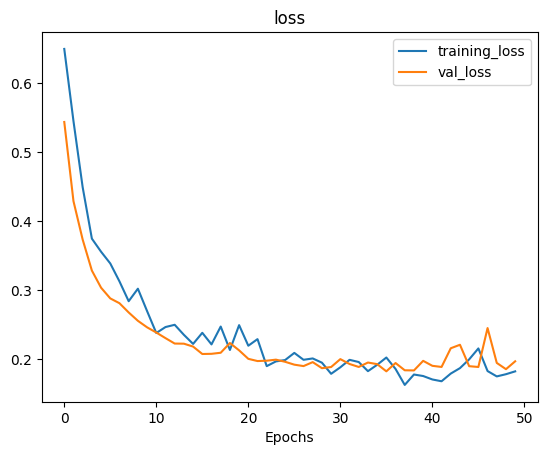

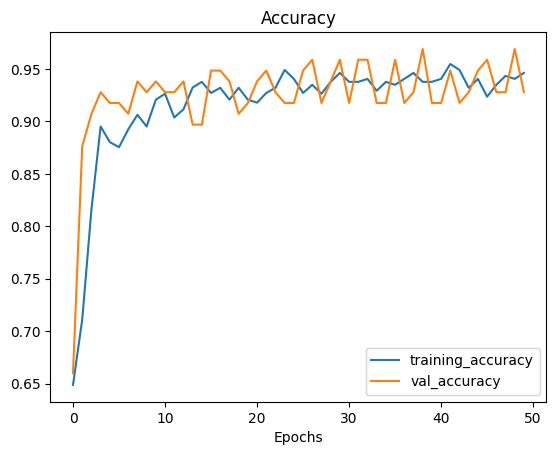

In [26]:
plot_loss_curves(H)

And finally let's check the result

[INFO] loading model and label binarizer...
[INFO] running selective search...
[INFO] proposal shape: (200, 224, 224, 3)
[INFO] classifying proposals...
7/7 [==============================] - 1s 140ms/step
[INFO] applying NMS...
show the output after *before* running NMS


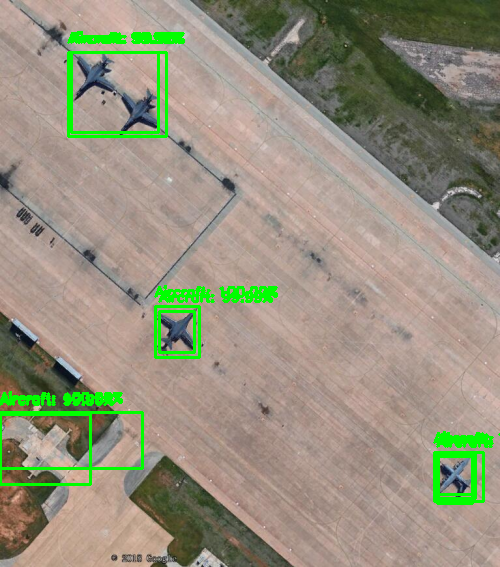

show the output image *after* running NMS


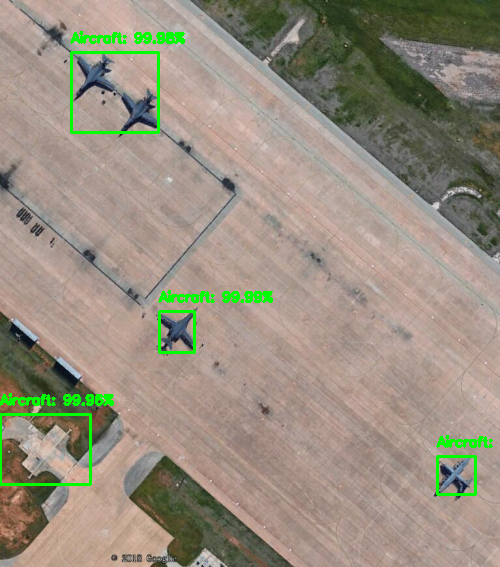

-1

In [30]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
from google.colab.patches import cv2_imshow


print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(ENCODER_PATH, "rb").read())

MIN_PROBA = 0.001

image = cv2.imread('/content/military-aircraft-recognition-dataset/JPEGImages/2.jpg', cv2.IMREAD_COLOR)
image = imutils.resize(image, width=500)

print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()


proposals = []
boxes = []


for (x, y, w, h) in rects[:MAX_PROPOSALS_INFER]:
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, INPUT_SIZE,
		interpolation=cv2.INTER_CUBIC)

	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

print("[INFO] classifying proposals...")
proba = model.predict(proposals)

print("[INFO] applying NMS...")
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == "aircraft")[0]

boxes = boxes[idxs]
proba = proba[idxs][:, 1]


idxs = np.where(proba <= MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

clone = image.copy()

for (box, prob) in zip(boxes, proba):
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Aircraft: {:.2f}%".format((1-prob) * 100)
	cv2.putText(clone, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

print("show the output after *before* running NMS")
cv2_imshow(clone)


boxIdxs = non_max_suppression(boxes, proba)

for i in boxIdxs:
	(startX, startY, endX, endY) = boxes[i]
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Aircraft: {:.2f}%".format((1- proba[i]) * 100)
	cv2.putText(image, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

print("show the output image *after* running NMS")
cv2_imshow(image)
cv2.waitKey(0)